In [ ]:
!pip install peakutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def scale(img, xScale, yScale):
    res = cv2.resize(img, None, fx=xScale, fy=yScale, interpolation=cv2.INTER_AREA)
    return res


def crop(infile, height, width):
    im = Image.open(infile)
    imgwidth, imgheight = im.size
    for i in range(imgheight // height):
        for j in range(imgwidth // width):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            yield im.crop(box)


def averagePixels(path):
    r, g, b = 0, 0, 0
    count = 0
    pic = Image.open(path)
    for x in range(pic.size[0]):
        for y in range(pic.size[1]):
            imgData = pic.load()
            tempr, tempg, tempb = imgData[x, y]
            r += tempr
            g += tempg
            b += tempb
            count += 1
    return (r / count), (g / count), (b / count), count

def convert_frame_to_grayscale(frame):
    grayframe = None
    gray = None
    if frame is not None:
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = scale(gray, 1, 1)
        grayframe = scale(gray, 1, 1)
        gray = cv2.GaussianBlur(gray, (9, 9), 0.0)
    return grayframe, gray

def prepare_dirs(keyframePath, imageGridsPath, csvPath):
    if not os.path.exists(keyframePath):
        os.makedirs(keyframePath)
    if not os.path.exists(imageGridsPath):
        os.makedirs(imageGridsPath)
    if not os.path.exists(csvPath):
        os.makedirs(csvPath)


def plot_metrics(indices, lstfrm, lstdiffMag):
    plt.plot(indices, y[indices], "x")
    l = plt.plot(lstfrm, lstdiffMag, 'r-')
    plt.xlabel('frames')
    plt.ylabel('pixel difference')
    plt.title("Pixel value differences from frame to frame and the peak values")
    # plt.show()

In [ ]:

import csv
import numpy as np
import time
import peakutils

def keyframeDetection(source,  Thres=0.3, plotMetrics=True, verbose=False):

    cap = cv2.VideoCapture(source)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  
    if (cap.isOpened()== False):
        print("Error opening video file")

    lstfrm = []
    lstdiffMag = []
    timeSpans = []
    images = []
    full_color = []
    lastFrame = None
    Start_time = time.process_time()
    
    # Read until video is completed
    for i in range(length):
        ret, frame = cap.read()
        grayframe, blur_gray = convert_frame_to_grayscale(frame)

        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) - 1
        lstfrm.append(frame_number)
        images.append(grayframe)
        full_color.append(frame)
        if frame_number == 0:
            lastFrame = blur_gray

        diff = cv2.subtract(blur_gray, lastFrame)
        diffMag = cv2.countNonZero(diff)
        lstdiffMag.append(diffMag)
        stop_time = time.process_time()
        time_Span = stop_time-Start_time
        timeSpans.append(time_Span)
        # lastFrame = blur_gray
        if(diffMag >= 125000):
          # cv2.imshow('frame',lastFrame)
          plt.imshow(cv2.cvtColor(lastFrame, cv2.COLOR_BGR2RGB))
              # as opencv loads in BGR format by default, we want to show it in RGB.
          plt.show()

        lastFrame = blur_gray

    cap.release()
    y = np.array(lstdiffMag)
    base = peakutils.baseline(y, 2)
    indices = peakutils.indexes(y-base, Thres, min_dist=1)

    plt.plot(indices, y[indices], "x")
    l = plt.plot(lstfrm, lstdiffMag, 'r-')
    plt.xlabel('frames')
    plt.ylabel('pixel difference')
    plt.title("Pixel value differences from frame to frame and the peak values")
    plt.show()

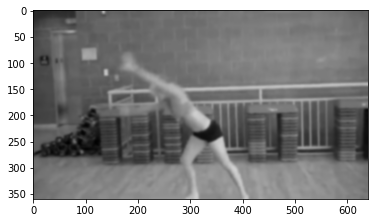

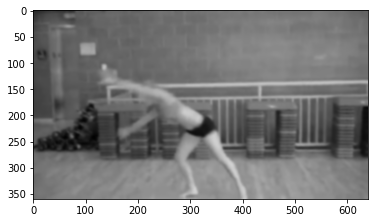

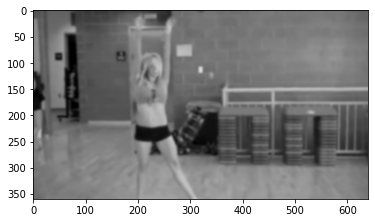

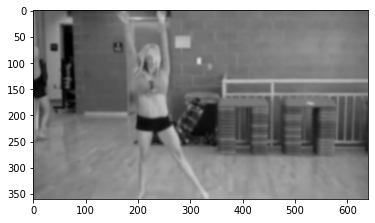

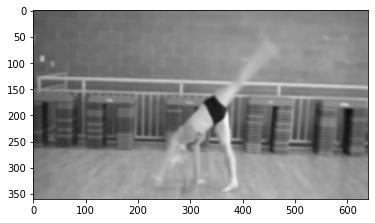

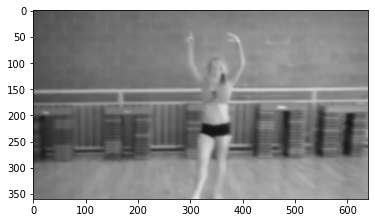

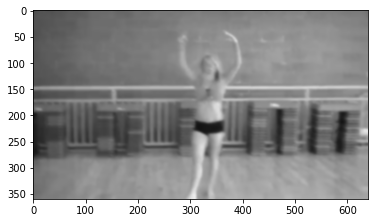

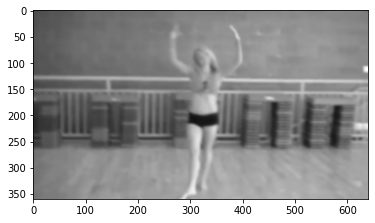

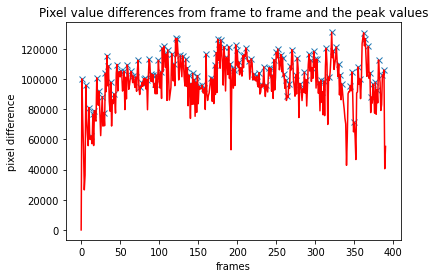

In [ ]:
keyframeDetection("/content/drive/MyDrive/import/Cartwheel.mp4")

In [ ]:
# if length of shot >= 2sec

def lucas_kanade_method(video_path):
    # Read the video
    cap = cv2.VideoCapture(video_path)
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for Lucas Kanade optical flow

    lk_params = dict( winSize=(15, 15),  maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),)
    # Create random colors
    color = np.random.randint(0, 255, (100, 3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)